

If the total sum of numbers is greater than 5, the label is 1 (True).
Otherwise, the label is 0 (False).

**Step 1 – Imports and Setup**

In [2]:
## Import PyTorch core modules


#the main PyTorch library
import torch 
#for building neural network layers
import torch.nn as nn 
#torch.optim – for optimizers (e.g., Adam)
import torch.optim as optim
## For creating small datasets, makes it easy to feed data in mini-batches
from torch.utils.data import DataLoader, TensorDataset

**Step 2 – Create a Tiny Toy Dataset**

In [4]:
# Create a toy dataset
# We’ll create 200 sequences, each with 10 numbers between 0 and 1
n_samples = 200
seq_len = 10
features = 1

# Generate random sequences between 0 and 1
X = torch.rand(n_samples, seq_len, features)

# Label = 1 if sum of numbers in a sequence > 5 else 0
y = (X.sum(dim=1) > 5).float()

print("Example sequence:", X[0].squeeze().numpy())
print("Label:", y[0].item())

# Create DataLoader for mini-batching
#TensorDataset pairs (X, y) so each batch contains inputs and their labels.
dataset = TensorDataset(X, y)
#DataLoader feeds 16 samples at a time and randomizes order each epoch.
loader = DataLoader(dataset, batch_size=16, shuffle=True)

Example sequence: [0.29600322 0.38525206 0.63783234 0.4075833  0.6893758  0.7096722
 0.66813153 0.49961233 0.10838211 0.37292427]
Label: 0.0


**Step 3 – Define the Feed-Forward Neural Network**

Input (10 numbers)
   ↓ flatten
Linear(10→16) → ReLU
   ↓
Linear(16→1) → Sigmoid
   ↓
Output: probability of “sum > 5” /close to 1 means “sum > 5”, close to 0 means “sum ≤ 5”.


In [6]:
class FeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #removes the sequence dimension; FFNN sees only a flat vector.
            nn.Flatten(),              # flatten (batch, seq_len, features) → (batch, seq_len * features) , turn [batch, 10, 1] → [batch, 10]
            #dense (fully connected) layer with a inputs and b outputs 
            nn.Linear(seq_len * features, 16), # input layer (10 → 16)
            #introduces non-linearity (important for learning)
            nn.ReLU(), # activation for non-linearity
            nn.Linear(16, 1), # output layer (16 → 1)
            #ensures the final number is between 0 and 1 (like probability).
            nn.Sigmoid() # convert output to probability 0–1
        )

    def forward(self, x):
        return self.model(x)


        


**Step 4 – Initialize the Model, Loss Function, and Optimizer**

In [10]:

# Initialize model, loss, optimizer
# Loss: measures how far prediction is from truth.
ffnn = FeedForwardNN()
criterion = nn.BCELoss()                # binary cross-entropy for binary classification
optimizer = optim.Adam(ffnn.parameters(), lr=0.01)


**Step 5 – Training Loop (Core Learning Process)**

In [13]:
def train_model(model, loader, epochs=5):
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in loader:
            optimizer.zero_grad()               # reset gradients from last batch
            preds = model(batch_x)              # forward pass → predictions (shape [batch,1])
            if batch_y.ndim == 1:               # only add dim if missing
                batch_y = batch_y.unsqueeze(1)     # shape targets to [batch,1]
            loss = criterion(preds, batch_y)    # compare preds vs true labels
            loss.backward()                     # compute gradients
            optimizer.step()                    # update weights
            total_loss += loss.item()           # accumulate loss for reporting
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f}")

train_model(ffnn, loader)

Epoch 1 | Loss: 0.5542
Epoch 2 | Loss: 0.5176
Epoch 3 | Loss: 0.4803
Epoch 4 | Loss: 0.4534
Epoch 5 | Loss: 0.4183


**Step 6 – Testing One Prediction**

In [17]:
with torch.no_grad():  # disable gradient tracking for inference
    sample = X[0].unsqueeze(0)  # add batch dimension
    pred = ffnn(sample)
    print(f"Predicted probability: {pred.item():.3f}")
    print(f"True label: {y[0].item():.0f}")


Predicted probability: 0.511
True label: 1


In [18]:
import matplotlib.pyplot as plt

# Put model in evaluation mode
ffnn.eval()

all_preds, all_labels = [], []

with torch.no_grad():  # no gradient tracking for inference
    for batch_x, batch_y in loader:
        preds = ffnn(batch_x)
        preds = preds.squeeze().numpy()      # shape (batch,)
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

all_preds = torch.tensor(all_preds)
all_labels = torch.tensor(all_labels)


/var/folders/36/c6m7q9gx4njbdgdy1y3mj9gm0000gn/T/ipykernel_77956/2557764111.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  all_labels = torch.tensor(all_labels)


**Plot Predicted Probabilities vs True Labels**

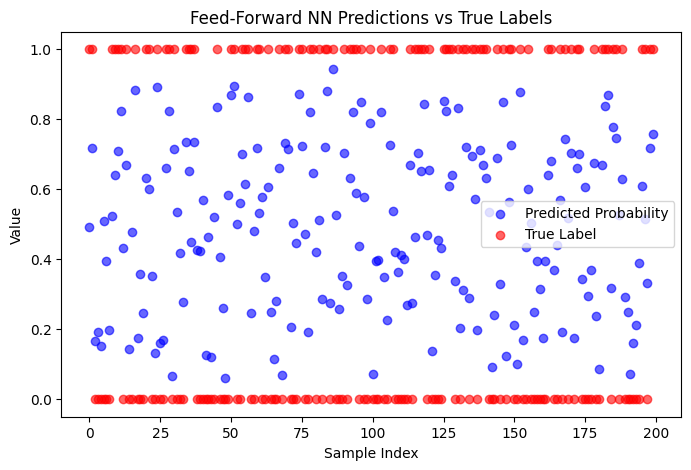

In [19]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(all_preds)), all_preds, color='blue', label='Predicted Probability', alpha=0.6)
plt.scatter(range(len(all_labels)), all_labels, color='red', label='True Label', alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Feed-Forward NN Predictions vs True Labels")
plt.legend()
plt.show()


**Plot the Loss Curve Across Epochs**

Epoch 1 | Loss: 0.2289
Epoch 2 | Loss: 0.2224
Epoch 3 | Loss: 0.2399
Epoch 4 | Loss: 0.1972
Epoch 5 | Loss: 0.1904
Epoch 6 | Loss: 0.1791
Epoch 7 | Loss: 0.1923
Epoch 8 | Loss: 0.1641
Epoch 9 | Loss: 0.1607
Epoch 10 | Loss: 0.1541


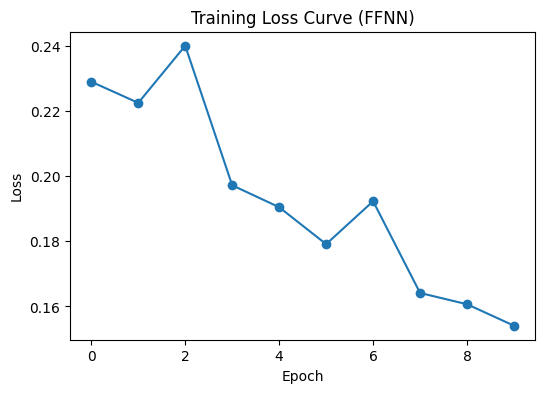

In [22]:
# modify train_model to return loss history
def train_model(model, loader, epochs=5):
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            preds = model(batch_x)
            batch_y = batch_y.view(-1, 1)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")
    return loss_history

# retrain to collect history
losses = train_model(ffnn, loader, epochs=10)

# visualize
plt.figure(figsize=(6,4))
plt.plot(losses, marker='o')
plt.title("Training Loss Curve (FFNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [24]:
pred_labels = (all_preds > 0.5).int()
correct = (pred_labels == all_labels.int()).sum().item()
accuracy = correct / len(all_labels)
print(f"Accuracy: {accuracy*100:.2f}%")


Accuracy: 9989.00%
